## 1. Cosmetics, chemicals... it's complicated
<p>Whenever I want to try a new cosmetic item, it's so difficult to choose. It's actually more than difficult. It's sometimes scary because new items that I've never tried end up giving me skin trouble. We know the information we need is on the back of each product, but it's really hard to interpret those ingredient lists unless you're a chemist. You may be able to relate to this situation.</p>
<p><img src="https://assets.datacamp.com/production/project_695/img/image_1.png" style="width:600px;height:400px;"></p>
<p>So instead of buying and hoping for the best, why don't we use data science to help us predict which products may be good fits for us? In this notebook, we are going to create a content-based recommendation system where the 'content' will be the chemical components of cosmetics. Specifically, we will process ingredient lists for 1472 cosmetics on Sephora via <a href="https://en.wikipedia.org/wiki/Word_embedding">word embedding</a>, then visualize ingredient similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh. Let's inspect our data first.</p>

In [2]:
# Import libraries
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np

# Load the data
df = pd.read_csv("cosmetics.csv")

# Check the first five rows 
display(df.sample(5))

# Inspect the types of products
df.Label.value_counts()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
415,Cleanser,OLEHENRIKSEN,Find Your Balance™ Oil Control Cleanser,25,4.5,"Water, Sodium Cocoyl Isethionate, Decyl Glucos...",1,0,0,1,0
637,Treatment,FRESH,Black Tea Age-Delay Firming Serum,75,3.9,"Water, Glycerin, Butylene Glycol, Jojoba Oil P...",1,1,1,1,1
710,Treatment,ALGENIST,GENIUS Ultimate Anti-Aging Vitamin C+ Serum,118,3.9,"Water, Glycerin, Butylene Glycol, 3-O-Ethyl As...",1,1,1,1,1
350,Cleanser,PETER THOMAS ROTH,Anti-Aging Cleansing Gel,38,4.4,"Water, Sodium Laureth Sulfate, Cocamidopropyl ...",0,0,0,0,0
1162,Eye cream,SEPHORA COLLECTION,Eye Mask - Cucumber - Anti-Puffiness,5,3.0,Visit the SEPHORA COLLECTION boutique,0,0,0,0,0


Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

## 2. Focus on one product category and one skin type
<p>There are six categories of product in our data (<strong><em>moisturizers, cleansers, face masks, eye creams</em></strong>, and <strong><em>sun protection</em></strong>) and there are five different skin types (<strong><em>combination, dry, normal, oily</em></strong> and <strong><em>sensitive</em></strong>). Because individuals have different product needs as well as different skin types, let's set up our workflow so its outputs (a t-SNE model and a visualization of that model) can be customized. For the example in this notebook, let's focus in on moisturizers for those with dry skin by filtering the data accordingly.</p>

In [20]:
# Filter for moisturizers
cleanser = df[df.Label == "Cleanser"]

# Filter for dry skin as well
cleanser_oil = cleanser[cleanser.Oily == 1]

# Reset index
cleanser_oil = cleanser_oil.reset_index(drop = True)


In [6]:
moisturizers = df[df.Label == "Moisturizer"]

# Filter for dry skin as well
moisturizers_dry = moisturizers[moisturizers.Dry == 1]

# Reset index
moisturizers_dry = moisturizers_dry.reset_index(drop = True)

In [21]:
facemask = df[df.Label == "Face Mask"]

# Filter for dry skin as well
facemask_comb = facemask[facemask.Combination == 1]

# Reset index
facemask_comb = facemask_comb.reset_index(drop = True)

## 3. Tokenizing the ingredients
<p>To get to our end goal of comparing ingredients in each product, we first need to do some preprocessing tasks and bookkeeping of the actual words in each product's ingredients list. The first step will be tokenizing the list of ingredients in <code>Ingredients</code> column. After splitting them into tokens, we'll make a binary bag of words. Then we will create a dictionary with the tokens, <code>ingredient_idx</code>, which will have the following format:</p>
<p>{ <strong><em>"ingredient"</em></strong>: index value, ... }</p>

In [73]:
# Initialize dictionary, list, and initial index
ingredient_idx = {}
corpus = []
idx = 0

# For loop for tokenization
for i in range(len(moisturizers_dry)):    
    ingredients = moisturizers_dry['Ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens = ingredients_lower.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredient_idx:
            ingredient_idx[ingredient] = idx
            idx += 1
# Check the result 

print("The index for decyl oleate is", ingredient_idx['decyl oleate'])


The index for decyl oleate is 25


In [74]:
# Initialize dictionary, list, and initial index
ingredient_idx1 = {}
corpus1 = []
idx1 = 0

# For loop for tokenization
for i in range(len(cleanser_oil)):    
    ingredients = cleanser_oil['Ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens1 = ingredients_lower.split(', ')
    corpus1.append(tokens1)
    for ingredient in tokens1:
        if ingredient not in ingredient_idx1:
            ingredient_idx1[ingredient] = idx1
            idx1 += 1
# Check the result
print("The index for potassium sorbate is", ingredient_idx1['potassium sorbate'])


The index for potassium sorbate is 53


In [75]:
ingredient_idx2 = {}
corpus2 = []
idx2 = 0

# For loop for tokenization
for i in range(len(facemask_comb)):    
    ingredients = facemask_comb['Ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens2 = ingredients_lower.split(', ')
    corpus2.append(tokens2)
    for ingredient in tokens2:
        if ingredient not in ingredient_idx2:
            ingredient_idx2[ingredient] = idx2
            idx2 += 1
# Check the result 

print("The index for acetyl tyrosine is", ingredient_idx2['acetyl tyrosine'])

The index for acetyl tyrosine is 1838


## 4. Initializing a document-term matrix (DTM)
<p>The next step is making a document-term matrix (DTM). Here each cosmetic product will correspond to a document, and each chemical composition will correspond to a term. This means we can think of the matrix as a <em>“cosmetic-ingredient”</em> matrix. The size of the matrix should be as the picture shown below.
<img src="https://assets.datacamp.com/production/project_695/img/image_2.PNG" style="width:600px;height:250px;">
To create this matrix, we'll first make an empty matrix filled with zeros. The length of the matrix is the total number of cosmetic products in the data. The width of the matrix is the total number of ingredients. After initializing this empty matrix, we'll fill it in the following tasks. </p>

In [29]:
# Get the number of items and tokens 
M = len(moisturizers_dry)
N = len(ingredient_idx)

# Initialize a matrix of zeros
A = np.zeros((M, N))


In [30]:
# Get the number of items and tokens 
M1 = len(cleanser_oil)
N1 = len(ingredient_idx1)

# Initialize a matrix of zeros
A1 = np.zeros((M1, N1))


In [31]:
# Get the number of items and tokens 
M2 = len(facemask_comb)
N2 = len(ingredient_idx2)

# Initialize a matrix of zeros
A2 = np.zeros((M2, N2))


## 5. Creating a counter function
<p>Before we can fill the matrix, let's create a function to count the tokens (i.e., an ingredients list) for each row. Our end goal is to fill the matrix with 1 or 0: if an ingredient is in a cosmetic, the value is 1. If not, it remains 0. The name of this function, <code>oh_encoder</code>, will become clear next.</p>

In [38]:
# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        # Get the index for each ingredient
        idx = ingredient_idx[ingredient]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x

In [55]:
# Define the oh_encoder function
def oh_encoder_1(tokens1):
    x1 = np.zeros(N1)
    for ingredient in tokens1:
        # Get the index for each ingredient
        idx1 = ingredient_idx1[ingredient]
        # Put 1 at the corresponding indices
        x1[idx1] = 1
    return x1

In [56]:
# Define the oh_encoder function
def oh_encoder_2(tokens2):
    x2 = np.zeros(N2)
    for ingredient in tokens2:
        # Get the index for each ingredient
        idx2 = ingredient_idx2[ingredient]
        # Put 1 at the corresponding indices
        x2[idx2] = 1
    return x2

# 6. The Cosmetic-Ingredient matrix!
<p>Now we'll apply the <code>oh_encoder()</code> functon to the tokens in <code>corpus</code> and set the values at each row of this matrix. So the result will tell us what ingredients each item is composed of. For example, if a cosmetic item contains <em>water, niacin, decyl aleate</em> and <em>sh-polypeptide-1</em>, the outcome of this item will be as follows. 
<img src="https://assets.datacamp.com/production/project_695/img/image_3.PNG" style="width:800px;height:400px;">
This is what we called one-hot encoding. By encoding each ingredient in the items, the <em>Cosmetic-Ingredient</em> matrix will be filled with binary values. </p>

In [57]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i = i + 1

In [76]:
# Make a document-term matrix
i = 0
for tokens1 in corpus1:
    A1[i, :] = oh_encoder_1(tokens1)
    i = i + 1

In [77]:
# Make a document-term matrix
i = 0
for tokens2 in corpus2:
    A2[i, :] = oh_encoder_2(tokens2)
    i = i + 1

## 7. Dimension reduction with t-SNE
<p>The dimensions of the existing matrix is (190, 2233), which means there are 2233 features in our data. For visualization, we should downsize this into two dimensions. We'll use t-SNE for reducing the dimension of the data here.</p>
<p><strong><a href="https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding">T-distributed Stochastic Neighbor Embedding (t-SNE)</a></strong> is a nonlinear dimensionality reduction technique that is well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, this technique can reduce the dimension of data while keeping the similarities between the instances. This enables us to make a plot on the coordinate plane, which can be said as vectorizing. All of these cosmetic items in our data will be vectorized into two-dimensional coordinates, and the distances between the points will indicate the similarities between the items. </p>

In [78]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A)

# Make X, Y columns 
moisturizers_dry['X'] = tsne_features[:,0]
moisturizers_dry['Y'] = tsne_features[:,1]

In [81]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A1)

# Make X, Y columns 
cleanser_oil['X1'] = tsne_features[:,0]
cleanser_oil['Y1'] = tsne_features[:,1]

In [82]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A2)

# Make X, Y columns 
facemask_comb['X2'] = tsne_features[:,0]
facemask_comb['Y2'] = tsne_features[:,1]

## 8. Let's map the items with Bokeh
<p>We are now ready to start creating our plot. With the t-SNE values, we can plot all our items on the coordinate plane. And the coolest part here is that it will also show us the name, the brand, the price and the rank of each item. Let's make a scatter plot using Bokeh and add a hover tool to show that information. Note that we won't display the plot yet as we will make some more additions to it.</p>

In [83]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

# Make a source and a scatter plot  
source = ColumnDataSource(moisturizers_dry)
plot = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot.circle(x = 'X', 
    y = 'Y', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

Loading BokehJS ...

GlyphRenderer(id='1039', ...)

In [86]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

# Make a source and a scatter plot  
source = ColumnDataSource(cleanser_oil)
plot1 = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot1.circle(x = 'X1', 
    y = 'Y1', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

Loading BokehJS ...

GlyphRenderer(id='1162', ...)

In [88]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

# Make a source and a scatter plot  
source = ColumnDataSource(facemask_comb)
plot2 = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot2.circle(x = 'X2', 
    y = 'Y2', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

Loading BokehJS ...

GlyphRenderer(id='1204', ...)

## 9. Adding a hover tool
<p>Why don't we add a hover tool? Adding a hover tool allows us to check the information of each item whenever the cursor is directly over a glyph. We'll add tooltips with each product's name, brand, price, and rank (i.e., rating).</p>

In [89]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('Item', '@Name'), 
                              ('Brand', '@Brand'), 
                              ('Price', '$@Price'), 
                              ('Rank', '@Rank')])
plot.add_tools(hover)

In [90]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('Item', '@Name'), 
                              ('Brand', '@Brand'), 
                              ('Price', '$@Price'), 
                              ('Rank', '@Rank')])
plot1.add_tools(hover)

In [91]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('Item', '@Name'), 
                              ('Brand', '@Brand'), 
                              ('Price', '$@Price'), 
                              ('Rank', '@Rank')])
plot2.add_tools(hover)

## 10. Mapping the cosmetic items
<p>Finally, it's show time! Let's see how the map we've made looks like. Each point on the plot corresponds to the cosmetic items. Then what do the axes mean here? The axes of a t-SNE plot aren't easily interpretable in terms of the original data. Like mentioned above, t-SNE is a visualizing technique to plot high-dimensional data in a low-dimensional space. Therefore, it's not desirable to interpret a t-SNE plot quantitatively.</p>
<p>Instead, what we can get from this map is the distance between the points (which items are close and which are far apart). The closer the distance between the two items is, the more similar the composition they have. Therefore this enables us to compare the items without having any chemistry background.</p>

In [10]:
# Plot the map
show(plot)

In [92]:
# Plot the map
show(plot1)

In [93]:
# Plot the map
show(plot2)

## 11. Comparing two products
<p>Since there are so many cosmetics and so many ingredients, the plot doesn't have many super obvious patterns that simpler t-SNE plots can have (<a href="https://campus.datacamp.com/courses/unsupervised-learning-in-python/visualization-with-hierarchical-clustering-and-t-sne?ex=10">example</a>). Our plot requires some digging to find insights, but that's okay!</p>
<p>Say we enjoyed a specific product, there's an increased chance we'd enjoy another product that is similar in chemical composition.  Say we enjoyed AmorePacific's <a href="https://www.sephora.com/product/color-control-cushion-compact-broad-spectrum-spf-50-P378121">Color Control Cushion Compact Broad Spectrum SPF 50+</a>. We could find this product on the plot and see if a similar product(s) exist. And it turns out it does! If we look at the points furthest left on the plot, we see  LANEIGE's <a href="https://www.sephora.com/product/bb-cushion-hydra-radiance-P420676">BB Cushion Hydra Radiance SPF 50</a> essentially overlaps with the AmorePacific product. By looking at the ingredients, we can visually confirm the compositions of the products are similar (<em>though it is difficult to do, which is why we did this analysis in the first place!</em>), plus LANEIGE's version is $22 cheaper and actually has higher ratings.</p>
<p>It's not perfect, but it's useful. In real life, we can actually use our little ingredient-based recommendation engine help us make educated cosmetic purchase choices.</p>

In [11]:
# Print the ingredients of two similar cosmetics
cosmetic_1 = moisturizers_dry[moisturizers_dry['Name'] == "Color Control Cushion Compact Broad Spectrum SPF 50+"]
cosmetic_2 = moisturizers_dry[moisturizers_dry['Name'] == "BB Cushion Hydra Radiance SPF 50"]

# Display each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
45,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60,4.0,"Phyllostachis Bambusoides Juice, Cyclopentasil...",1,1,1,1,1,-9.419198,-335.968231


['Phyllostachis Bambusoides Juice, Cyclopentasiloxane, Cyclohexasiloxane, Peg-10 Dimethicone, Phenyl Trimethicone, Butylene Glycol, Butylene Glycol Dicaprylate/Dicaprate, Alcohol, Arbutin, Lauryl Peg-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Polyhydroxystearic Acid, Sodium Chloride, Polymethyl Methacrylate, Aluminium Hydroxide, Stearic Acid, Disteardimonium Hectorite, Triethoxycaprylylsilane, Ethylhexyl Palmitate, Lecithin, Isostearic Acid, Isopropyl Palmitate, Phenoxyethanol, Polyglyceryl-3 Polyricinoleate, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Disodium Edta, Trimethylsiloxysilicate, Ethylhexyglycerin, Dimethicone/Vinyl Dimethicone Crosspolymer, Water, Silica, Camellia Japonica Seed Oil, Camillia Sinensis Leaf Extract, Caprylyl Glycol, 1,2-Hexanediol, Fragrance, Titanium Dioxide, Iron Oxides (Ci 77492, Ci 77491, Ci77499).']


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
55,Moisturizer,LANEIGE,BB Cushion Hydra Radiance SPF 50,38,4.3,"Water, Cyclopentasiloxane, Zinc Oxide (CI 7794...",1,1,1,1,1,-31.170496,-359.229309


['Water, Cyclopentasiloxane, Zinc Oxide (CI 77947), Ethylhexyl Methoxycinnamate, PEG-10 Dimethicone, Cyclohexasiloxane, Phenyl Trimethicone, Iron Oxides (CI 77492), Butylene Glycol Dicaprylate/Dicaprate, Niacinamide, Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Titanium Dioxide (CI 77891 , Iron Oxides (CI 77491), Butylene Glycol, Sodium Chloride, Iron Oxides (CI 77499), Aluminum Hydroxide, HDI/Trimethylol Hexyllactone Crosspolymer, Stearic Acid, Methyl Methacrylate Crosspolymer, Triethoxycaprylylsilane, Phenoxyethanol, Fragrance, Disteardimonium Hectorite, Caprylyl Glycol, Yeast Extract, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Trimethylsiloxysilicate, Polysorbate 80, Disodium EDTA, Hydrogenated Lecithin, Dimethicone/Vinyl Dimethicone Crosspolymer, Mica (CI 77019), Silica, 1,2-Hexanediol, Polypropylsilsesquioxane, Chenopodium Quinoa Seed Extract, Magnesium Sulfate, Calcium Chloride

In [95]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.palettes import Category20c
from bokeh.transform import factor_cmap

# Load your cosmetic data into a DataFrame (replace 'cosmetic_data.csv' with your data)
# The DataFrame should include columns for cosmetic name, ingredients, and product category.
df = pd.read_csv('cosmetics.csv')

# Initialize a CountVectorizer and create the document-term matrix (DTM)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['Ingredients'])

# Reduce dimensionality using PCA with init="random"
pca = PCA(n_components=2, svd_solver="randomized")  # Set svd_solver to "randomized"
dtm_2d = pca.fit_transform(dtm.toarray())  # Convert the sparse matrix to dense for PCA

# Add the 2D coordinates to the DataFrame
df['pca_x'] = dtm_2d[:, 0]
df['pca_y'] = dtm_2d[:, 1]

# Define a Bokeh color palette for product categories
categories = df['Label'].unique()
palette = Category20c[len(categories)]
color_map = factor_cmap('Label', palette=palette, factors=categories)

# Create a Bokeh figure
p = figure(width=800, height=600, title="Cosmetic Ingredients Similarity")

# Create a Bokeh data source
source = ColumnDataSource(data=df)

# Create the scatter plot with color-coded product categories
p.scatter('pca_x', 'pca_y', source=source, size=8, color=color_map, legend_field='Label')

# Customize the plot legend
p.legend.title = "Product Category"
p.legend.label_text_font_size = "10px"
p.legend.title_text_font_size = "12px"

# Add a hover tool to display cosmetic information
hover = HoverTool()
hover.tooltips = [("Cosmetic", "@Name"), ("Category", "@Label")]
p.add_tools(hover)

# Show the plot
show(p)


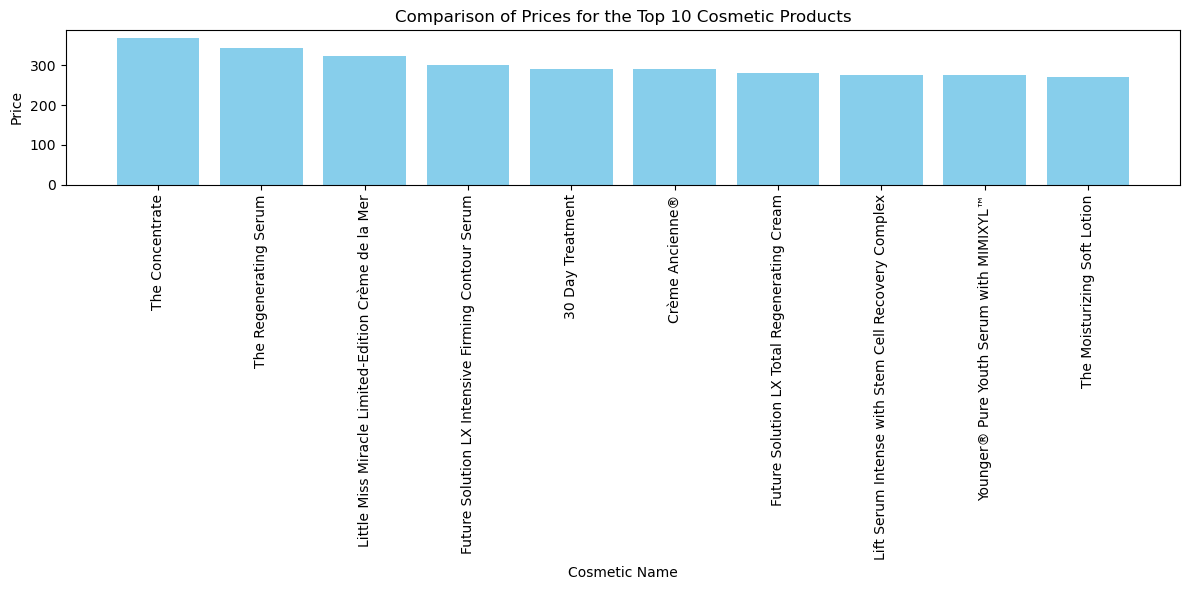

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your cosmetic data into a DataFrame (replace 'cosmetics.csv' with your data)
# The DataFrame should include columns for cosmetic name and price.
df = pd.read_csv('cosmetics.csv')

# Sort the DataFrame by price in descending order and select the top 10 products
top_10_products = df.sort_values(by='Price', ascending=False).head(10)

# Create a bar chart to compare prices of the top 10 products
plt.figure(figsize=(12, 6))
plt.bar(top_10_products['Name'], top_10_products['Price'], color='skyblue')
plt.xlabel('Cosmetic Name')
plt.ylabel('Price')
plt.title('Comparison of Prices for the Top 10 Cosmetic Products')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()


In [35]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn

# Load your cosmetic data into a DataFrame (replace 'cosmetics.csv' with your file name)
df = pd.read_csv('cosmetics.csv')  # Change the filename to 'cosmetics.csv'

# Define price categories based on your criteria (e.g., low, medium, high)
low_price_threshold = 10  # Example low price threshold
high_price_threshold = 50  # Example high price threshold

# Create a new column "price_category" based on the price ranges
df['price_category'] = pd.cut(df['Price'], bins=[0, low_price_threshold, high_price_threshold, float('inf')],
                              labels=['Low', 'Medium', 'High'])

# Map price categories to numeric values
price_category_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['price_category_numeric'] = df['price_category'].map(price_category_mapping)

# Initialize a CountVectorizer and create the document-term matrix (DTM)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df['Ingredients'])

# Reduce dimensionality using PCA with init="random"
pca = PCA(n_components=2, svd_solver="randomized")
dtm_2d = pca.fit_transform(dtm.toarray())

# Add the 2D coordinates to the DataFrame
df['pca_x'] = dtm_2d[:, 0]
df['pca_y'] = dtm_2d[:, 1]

# Define a Bokeh color palette for price categories
palette = RdYlGn[3]  # Example color palette

# Create a Bokeh figure
p = figure(width=800, height=600, title="Cosmetic Ingredients and Prices")

# Create a Bokeh data source
source = ColumnDataSource(data=df)

# Create the scatter plot with color-coded price categories using linear_cmap
color_mapper = linear_cmap(field_name='price_category_numeric', palette=palette, low=1, high=3)
p.scatter('pca_x', 'pca_y', source=source, size=8, color=color_mapper, legend_field='price_category')

# Customize the plot legend
p.legend.title = "Price Category"
p.legend.label_text_font_size = "10px"
p.legend.title_text_font_size = "12px"

# Add a hover tool to display cosmetic information
hover = HoverTool()
hover.tooltips = [("Cosmetic", "@Name"), ("Label", "@price_category")]
p.add_tools(hover)

# Show the plot
show(p)


In [40]:
ingredients_column = df['Ingredients']
print(ingredients_column)

0       Algae (Seaweed) Extract, Mineral Oil, Petrolat...
1       Galactomyces Ferment Filtrate (Pitera), Butyle...
2       Water, Dicaprylyl Carbonate, Glycerin, Ceteary...
3       Algae (Seaweed) Extract, Cyclopentasiloxane, P...
4       Water, Snail Secretion Filtrate, Phenyl Trimet...
                              ...                        
1467    Water, Alcohol Denat., Potassium Cetyl Phospha...
1468    Water, Isododecane, Dimethicone, Butyloctyl Sa...
1469    Water, Dihydroxyacetone, Glycerin, Sclerocarya...
1470    Water, Dihydroxyacetone, Propylene Glycol, PPG...
1471                        Visit the DERMAFLASH boutique
Name: Ingredients, Length: 1472, dtype: object


In [96]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load your cosmetic data into a DataFrame (replace 'cosmetics.csv' with your file name)
df = pd.read_csv('cosmetics.csv')  # Change the filename to 'cosmetics.csv'

# Define the specific categories you want to analyze
desired_categories = ['Cleanser', 'Moisturizer', 'Face Mask']

# Filter the DataFrame to include only products in the desired categories
filtered_df = df[df['Label'].isin(desired_categories)]

# Initialize a CountVectorizer and create the document-term matrix (DTM)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(filtered_df['Ingredients'])

# Calculate the ingredient similarity using cosine similarity
ingredient_similarity = cosine_similarity(dtm)

# Print the ingredient similarity matrix (this will be a square matrix)
print(ingredient_similarity)


[[1.         0.10206207 0.20007309 ... 0.21214781 0.18710571 0.29873219]
 [0.10206207 1.         0.31457643 ... 0.14258796 0.1253201  0.14071951]
 [0.20007309 0.31457643 1.         ... 0.15108989 0.24187192 0.29822007]
 ...
 [0.21214781 0.14258796 0.15108989 ... 1.         0.21783329 0.30320304]
 [0.18710571 0.1253201  0.24187192 ... 0.21783329 1.         0.52401093]
 [0.29873219 0.14071951 0.29822007 ... 0.30320304 0.52401093 1.        ]]
